In [1]:
from numpy import *

def DSThreshold(dataMat, dimen, threshVal, ineq):
    retArr = ones((dataMat.shape[0], 1))
    if ineq == 'lt':
        retArr[dataMat[:, dimen] <= threshVal] = -1.0
    else:
        retArr[dataMat[:, dimen] > threshVal] = -1.0
    return retArr

def DS(data, classLabels, D):
    dataMat = mat(data) 
    labelMat = mat(classLabels).T
    m, n = dataMat.shape
    numSteps = 10.0
    bestStump = {} 
    bestClassEst = mat(zeros((m, 1)))
    minError = inf
    
    for i in range(n):
        rangeMin = min(dataMat[:, i]); rangeMax = max(dataMat[:, i])
        stepSize = (rangeMax - rangeMin) / numSteps

        for j in range(-1, int(numSteps)+1):
            for inequal in ['lt', 'gt']:
                threshVal = rangeMin + float(j) * stepSize
                predicatedVal = DSThreshold(dataMat, i, threshVal, inequal)
                errArr = mat(ones((m, 1)))
                
                errArr[predicatedVal == labelMat] = 0
                weightedError = D.T * errArr

                if weightedError < minError:
                    minError = weightedError
                    bestClassEst = predicatedVal.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
                    
    return bestStump, minError, bestClassEst   


def AdaBoostDS(data, classLabels, numIter = 50):
    bestStumpArr = []
    m = data.shape[0]
    D = mat(ones((m,1))/m)
    aggClassEst = mat(zeros((m,1)))
    for i in range(numIter):
        bestStump, error, bestClassEst = DS(data, classLabels, D)
#        print('D:', D.T)
        alpha = float(0.5 * log((1.0 - error)/max(error, 1e-16)))
        bestStump['alpha'] = alpha
        bestStumpArr.append(bestStump)
#        print('ClassEst:', bestClassEst.T)
        
        # multiply(): element-wise product. class real result X estimation
        expon = multiply(-1 * alpha * mat(classLabels).T, bestClassEst)
        #exp(expon): calculate exp for each element in mat expon
        D = multiply(D, exp(expon)) / sum(D)
        
        # aggClassEst is float matrix.
        aggClassEst += alpha * bestClassEst
#        print('aggClassEst:', aggClassEst)
        
        # aggClassEst is float matrix, use its sign to compare with mat classLabels
        aggError = multiply(sign(aggClassEst) != mat(classLabels).T, ones((m,1)))
        errorRate = sum(aggError)/m
#        print('total error:', errorRate)
        
        if errorRate == 0.0:
            break
        
    return bestStumpArr

# loop through
def AdaBoostClassify(dataToClass, classifierArr):
    dataMat = mat(dataToClass)
    m = dataMat.shape[0]
    aggClassEst = mat(zeros((m, 1)))
    for i in range(len(classifierArr)):
        classEst = DSThreshold(dataMat, classifierArr[i]['dim'], classifierArr[i]['thresh'], classifierArr[i]['ineq'])
        aggClassEst += classifierArr[i]['alpha'] * classEst
#        print(aggClassEst)
    return sign(aggClassEst)

# calculate training and testing error
def ErrorCalculation(trainX, trainY, testX, testY):
    y_pred_train = AdaBoostClassify(dataToClass = trainX, classifierArr=adaboost_cls)
    training_error = sum(y_pred_train.flatten() != trainY)/len(trainY)
    
    y_pred_test = AdaBoostClassify(dataToClass = testX, classifierArr=adaboost_cls)
    testing_error = sum(y_pred_test.flatten() != testY)/len(testY)
    return training_error, testing_error

In [2]:
# Question 2
# generate training dataset
df3_train_X = random.standard_normal(20000)
df3_train_X = df3_train_X.reshape(2000,10)
rm1 =sum(df3_train_X**2, axis=1)

df3_train_Y = zeros(2000)
for i in range(0,2000):
    if rm1[i] >= 9.34:
        df3_train_Y[i] = 1
    else:
        df3_train_Y[i] = -1

# generate testing dataset
df3_test_X = random.standard_normal(100000)
df3_test_X = df3_test_X.reshape(10000,10)
rm2 =sum(df3_test_X**2, axis=1)

df3_test_Y = zeros(10000)
for i in range(0,10000):
    if rm2[i] >= 9.34:
        df3_test_Y[i] = 1
    else:
        df3_test_Y[i] = -1

In [3]:
results_train_E = []
results_test_E = []
for i in range(1,7000, 800):
    adaboost_cls = AdaBoostDS(data = df3_train_X, classLabels=df3_train_Y, numIter = i)
    results_train_E.append(ErrorCalculation(trainX = df3_train_X, trainY = df3_train_Y, testX = df3_test_X, testY = df3_test_Y)[0])
    results_test_E.append(ErrorCalculation(trainX = df3_train_X, trainY = df3_train_Y, testX = df3_test_X, testY = df3_test_Y)[1])


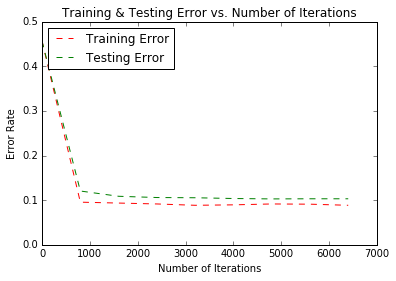

In [7]:
import matplotlib.pyplot as plt
plt.plot(range(1,7000, 800), results_train_E, 'r--')
plt.axis([1, 7000, 0, 0.5])

# error curves
plt.plot(range(1,7000, 800), results_test_E, 'r--', color='green')
plt.axis([1, 7000, 0, 0.5])
plt.legend(['Training Error', 'Testing Error'], loc='upper left')
plt.title('Training & Testing Error vs. Number of Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Error Rate')
plt.show()


In [ ]:
# The testing error continue to decrease for as long as I can run and wait for
# the algorithm to finish. I did not notice any significant increase after
# many trails with increasing number of iterations. As you can see for a
# example below, which indicates that the testing error is still decreasing

In [12]:
# Try interations = 6000
adaboost_cls = adaBoostDS(dataArr = df3_train_X, classLabels=df3_train_Y, numIter = 6000)
print("Testing error for iterations = 6000 is",ErrorCalculation(trainX = df3_train_X, trainY = df3_train_Y, testX = df3_test_X, testY = df3_test_Y)[1])

print("Training error for iterations = 6000 is",ErrorCalculation(trainX = df3_train_X, trainY = df3_train_Y, testX = df3_test_X, testY = df3_test_Y)[0])

Testing error for iterations = 6000 is 0.1029
Training error for iterations = 6000 is 0.0895
